In [1]:
#    ======================================
#     ,-----.                              
#    '  .--./ ,---.  ,---.  ,---.,--. ,--. 
#    |  |    | .-. |(  .-' | .-. |\  '  /  
#    '  '--'\' '-' '.-'  `)| '-' ' \   '   
#     `-----' `---' `----' |  |-'.-'  /    
#                          `--'  `---'     
#    ============ Cospy  15.01 ============

#    Instructions:
#
#   Modify only the fields with label MODIFY
#   The script may not work otherwise



In [2]:
#Import python packages 
#Usually you don't need to modify (remove packages)
#However, you may need to add packages

from cospy.equation_factory import * 
%matplotlib inline  

from IPython.display import display, HTML
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
import matplotlib.pyplot as plt 

from sympy.interactive import printing
printing.init_printing(use_latex=True)



:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:

#define problem's name and fields
#an existing problem will be overwritten 

##########    MODIFY: Any name may work.    ##########
problem_name = 'wave equation'   
######################################################

#define the variables:
#use the object Cospy_Fields to define the variables
variables=Cospy_Fields()

##################    MODIFY: Add any number of variables. ##################
# Use add_amr_variable to define variables for time-evolution 
# Use add_multigrid_variable to define variables for elliptic equation 
# Use add_auxiliary_variable to define variables which link amr and 
# multigrid equations (density for example) 
u = variables.add_amr_variable('u')
v = variables.add_amr_variable('v')
#############################################################################


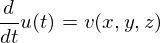

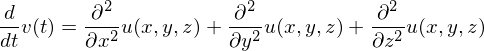

In [4]:
#define the right hand side of the equations:
#use the object Cospy_RHS to define the right hand side of the equations
#
equations = Cospy_Equations(variables)

##################    MODIFY: Add a RHS for each amr variable    ##################
#   equations should be of the form:
#   f'(t) = F(f_xx,f_yy,f_zz,f_x,f_y,f_z,f)
#   where f=[f1,f2,...,fn]
#   and fi in variables_amr
#   differential opperatios should be defined using sympy notation. 
a, b =symbols('a b')
equations.add_amr_rhs('u', v(x,y,z))
equations.add_amr_rhs('v', u(x,y,z).diff(x,2)+u(x,y,z).diff(y,2)+u(x,y,z).diff(z,2))

#equations.add_amr_rhs('v', a*u(x,y,z).diff(x,2)+u(x,y,z).diff(y,2)**b+v(x,y,z)*u(x,y,z).diff(z,2))
#############################################################################

#this will print you equations. Don't modify
equations.display()

##################    MODIFY: Add an elliptic operator for each multigrid variable    ##################
#   operator should be of the form:
#   A(f) D^2 f + B(D f)  + C(f) = S 
#   where f=[f1,f2,...,fn]
#   differential opperatios should be defined using sympy notation. 
#   
#equations.add_elliptic_operator('w', A=1,B=u(x,y,z).diff(x)+u(x,y,z).diff(y)+u(x,y,z).diff(z), C=0, S=0 )
#
#      NOT IMPLEMENTED YET
#


In [5]:
##################    MODIFY: Add a boundary condition for each amr variable   ##################
#   amr boundary condition should be one of:
#   a) Dirichlet u(at boundary) = value (value should be specified as argument)
#   b) Periodic (no argument required)
#

equations.add_amr_boundary('u', 'Periodic' , value=0)
equations.add_amr_boundary('v', 'Periodic' , value=0)

#############################################################################

#this will print the boundary condition. Don't modify
equations.boundary()




boundary condition for variable u is Periodic
boundary condition for variable v is Periodic


initial data for variable u is:


initial data for variable v is:


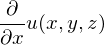

In [6]:
##################    MODIFY: Add a initial data for each amr variable   ##################
#   initial data should be ther right hand side of:
#
#   fi(t0)=F(x,y,z)
#
#   and fi  is an amr variable
#   differential opperatios should be defined using sympy notation. 
#   you must specify the arguments of the function
#   use: dudx, duddx and Lap_u to specify differential operators

equations.add_amr_initial_data('u', exp(-(x**2+y**2+z**2) ))
equations.add_amr_initial_data('v', u(x,y,z).diff(x,1)  )

#############################################################################

#this will print the boundary condition. Don't modify
equations.initial_data()

In [7]:
##################    REVIEW:   ##################
#   Check your equations, initial data and boundary condition
#
#   If the equation exists, it will be overwrite. 
#
#   click the make_equation box to write the equations to a source file. 
#   Be sure to change the problem name in your parameter file. 
#
interact(lambda make_equation: review_make_equation(problem_name,equations,make_equation) ,make_equation=False)
#############################################################################
print('')

SUMARY:
Problem name: wave equation
Warining: Problem exists, OVERWRITE?



In [8]:

def make_problem(problem_name, equations):

    dir_name = os.path.abspath(os.path.curdir+'/../')
    template_file_name = 'equation_template.py' 
    output_file = dir_name+'/'+problem_name.replace(' ','_')+'.py'    
  
    
    template_enviroment = Environment(
        autoescape=False,
        loader=FileSystemLoader(os.path.join(dir_name, 'templates')),
        trim_blocks=False)
    
    
    template = template_enviroment.get_template(template_file_name)
    
    templete_fields = dict()

    field_map = list()
    field_dict=dict()
    for k in equations.variables.amr_variables.keys():
        field_dict[k] = 'amr'
        field_map.append(sstr(k))

    templete_fields['field_map'] = field_map
        
    templete_fields['field_dict'] = field_dict

    templete_fields['field_list'] = list(equations.variables.amr_variables.keys())
    
    
    id_dict = dict()
    for id_f in equations.amr_initial_data:
        id_dict[id_f['variable']] = parse_expr(id_f['function'])
    templete_fields['id_dict'] = id_dict

    
    id_arg = dict()
    for arg in equations.amr_initial_data:
        id_dict[id_f['variable']] = parse_expr(id_f['function'])
    templete_fields['id_dict'] = id_dict

    
    
    rhs_dict = dict()
    
    for eq in equations.amr_equations:
        rhs_dict[sstr(eq['lhs'])] = parse_expr(eq['rhs'])
    
    templete_fields['rhs_dict']=rhs_dict
    
    boundary_dict = dict()
    for boundary in equations.amr_boundary:
        if boundary['condition'] == 'Dirichlet':
            boundary_dict[boundary['variable']] = boundary['condition']+':'+str(boundary['value'])
        elif boundary['condition'] == 'Periodic':
            boundary_dict[boundary['variable']] = boundary['condition']
 
           
            
    templete_fields['boundary_dict']=boundary_dict
    
    print(template.render(templete_fields))

    return
    with open(output_file, "w") as pfile:
        pfile.write(template.render(templete_fields))
        
    file_import=dir_name+'/equations.py'
    import_exist=False
    
    module_import = 'import cospy.'+problem_name.replace(' ','_')
    with open(file_import, "r") as ifile:
        for line in ifile:
            if 'import' in line:
                if module_import in line:
                    import_exist = True
                    break
    if not import_exist:
        with open(file_import, "a") as ifile:
            ifile.write(module_import+'\n')    
    
make_problem(problem_name, equations)

UndefinedError: 'id_arg' is undefined

In [71]:
def parse_derivative(var,axis, order):
    a = ['x','y','z']
    o = ['d','dd']
    return 'd'+var+o[order-1]+a[axis]
    
def parse_diff(var, x_axis, y_axis,z_axis):
    if x_axis * y_axis * z_axis ==0:
        if x_axis != 0:
            return parse_derivative(var,0,x_axis)
        if y_axis != 0:
            return parse_derivative(var,0,y_axis)
        if z_axis != 0:
            return parse_derivative(var,0,z_axis)
    if x_axis == y_axis  and y_axis == z_axis and x_axis == 2:
        return 'Lap_'+var
    
    logging.error('operator not implemented in parse_diff var %s, x axis %d, y axis %d z axis %d',var,x_axis,y_axis,z_axis)
    exit(1)

    
def parse_expr(expr):
    
    arg_list=list()
    for arg in expr.args:
        arg_list.append(parse_expr(arg))
        
    if expr.func.is_Add:       
        return '+'.join(arg_list)
    if expr.func.is_Mul:       
        return '*'.join(arg_list)
    if expr.func.is_Pow:       
        return '**'.join(arg_list)
    if expr.func.is_Derivative:   

        var = arg_list[0]
        x_der=0
        y_der=0
        z_der=0 
        for c in arg_list[1:]:
            if 'x' in c:
                x_der+=1
            elif 'y' in c:
                y_der+=1
            elif 'z' in c:
                z_der+=1 
        
        return parse_diff(var, x_der,y_der,z_der)


    if expr.func.is_Function:
        if len(expr.args) == 1:
            return sstr(expr.func)+'('+','.join(arg_list)+')'
        else:
            return sstr(expr.func)
    
    return sstr(expr)

parse_expr(equations.amr_initial_data[1]['function'])

'dudx'

In [79]:
def parse_args(expr, deept=0):
    arg_list=list()
    for arg in expr.args:
        arg_list.append(parse_args(arg,deept+1))
        
    if expr.func.is_Derivative:   
        var = arg_list[0]
        x_der=0
        y_der=0
        z_der=0 
        for c in arg_list[1:]:
            if 'x' in c:
                x_der+=1
            elif 'y' in c:
                y_der+=1
            elif 'z' in c:
                z_der+=1 
        
        print(var, x_der,y_der,z_der)
        

    if expr.func.is_Function:
        if len(expr.args) == 1:
            return sstr(expr.func)+'('+','.join(arg_list)+')'
        else:
            return sstr(expr.func)


    if expr.is_Symbol:   
        return sstr(expr)+','
    return ''.join(arg_list)
    
parse_args(equations.amr_initial_data[1]['function'])




u 1 0 0


'ux,'

In [32]:
id_f=equations.amr_initial_data[0]['function']



In [51]:
id_f.args[0].args[0].args[1].args[0].is_Symbol

True

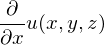

In [67]:
equations.amr_initial_data[1]['function']